In [1]:
import sys
sys.path.append("/sgai_overlap/")
from functions import *
import cmapy

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Only GPU 1 is visible to this code

In [2]:
savetest = True
if savetest == True:
    testorval = "test"
    seis_path = 'seistest.npy'
    label_path = 'faulttest.npy'
else:
    testorval = "val"
    seis_path = 'seismicval.npy'
    label_path = 'faultval.npy'

In [3]:
seis = np.load(seis_path)[:,800:1300,:]
fault = np.load(label_path)[:,800:1300,:]

In [4]:
IL, Z, XL = seis.shape
print(IL, Z, XL)

703 500 3174


In [5]:
im_height = Z
im_width = XL
splitsize = 96
stepsize = 96 #no overlap for distance test
overlapsize = splitsize-stepsize

In [6]:
horizontal_splits_number = int(np.ceil((im_width)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+2*overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+2*overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)

34
3264
45 45
6
576
38 38


In [7]:
halfoverlapsize = int(overlapsize/2)
print(halfoverlapsize)

0


In [8]:
t_start = time.time()
X_list = []
Y_list = []
for i in range(0,len(seis),5):
    img = seis[i]
    mask = fault[i]
    X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
    Y_list.extend(split_Image(mask,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.expand_dims(np.asarray(X_list).astype(np.float32),1)
Y = np.expand_dims(np.asarray(Y_list).astype(np.float32),1)
print(X.shape)
print(Y.shape)
print("read images in {} sec".format(time.time()-t_start))


28764
(96, 96)
read images in 2.5851213932037354 sec
(28764, 1, 96, 96)
(28764, 1, 96, 96)
read images in 4.970771551132202 sec


In [9]:
# idea from: https://www.kaggle.com/erikistre/pytorch-basic-u-net
class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,preprocessed_masks):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.images = preprocessed_images
        self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image,mask

In [10]:
faults_dataset_test = faultsDataset(X,Y)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [11]:
model_name = "unet" 
best_iou_threshold = 0.5
currentpath = "/sgai_overlap/"
device = torch.device("cuda")
if model_name == "unet":
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    modelname = "unet_LRoverlap_0.5Loss12_0.5Loss3_addafterepoch4_seed1"
    best_model_fpath = '{}/models/{}.model'.format(currentpath,modelname) 
elif model_name == "unet_fullconv":
    from model_zoo.UNET_fullconv import Unet
    model = Unet()
    print("use model Unet_fullconv")
    modelname = "unet_fullconv_withoutoverlap_seed1"
    best_model_fpath = '{}/models/{}.model'.format(currentpath,modelname) 
elif model_name == "deeplab":
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    modelname = "deeplab_LRoverlap_0.5Loss12_1Loss3_addafterepoch2"
    best_model_fpath = '{}/models/{}.model'.format(currentpath,modelname) 
elif model_name == "rcf":
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    modelname = "rcf_withoutoverlap"
    best_model_fpath = '{}/models/{}.model'.format(currentpath,modelname) 
elif model_name == "rcf_fullconv":
    from model_zoo.rcf_fullconv import RCF
    model = RCF()
    print("use model RCF")
    modelname = "rcf_fullconv_withoutoverlap_seed1"
    best_model_fpath = '{}/models/{}.model'.format(currentpath,modelname) 

# print(best_model_fpath)
# print(save_path)
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
summary(model, (1, splitsize, splitsize))#,device='cpu')

use model Unet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
         Dropout2d-4           [-1, 32, 96, 96]               0
            Conv2d-5           [-1, 32, 96, 96]           9,248
       BatchNorm2d-6           [-1, 32, 96, 96]              64
              ReLU-7           [-1, 32, 96, 96]               0
         Dropout2d-8           [-1, 32, 96, 96]               0
       double_conv-9           [-1, 32, 96, 96]               0
        MaxPool2d-10           [-1, 32, 48, 48]               0
           Conv2d-11           [-1, 64, 48, 48]          18,496
      BatchNorm2d-12           [-1, 64, 48, 48]             128
             ReLU-13           [-1, 64, 48, 48]               0
        Dropout2d-14    

In [18]:
losses_48 = []
splitsize = 96
center = (splitsize-1)/2
xx, yy = np.mgrid[:splitsize, :splitsize]
square = np.maximum(
    np.floor(np.abs(xx - center)) , 
    np.floor(np.abs(yy - center))).astype(np.int8)
# print(square)
t_start = time.time()
for images,masks in test_loader:
    images = Variable(images.cuda())
    outputs = model(images)
    y_preds = outputs
    if model_name == "rcf" or model_name == "rcf_fullconv":
        y_preds = outputs[-1]
    predictions = y_preds.detach().cpu()
    for distance in range (0,np.max(square)+1,1):
        distancemask = (square == distance)
        batchdistancemask = np.repeat(np.expand_dims(np.expand_dims(distancemask,0),0),len(predictions),axis=0)
        losssum = np.multiply(np.abs(predictions-masks),batchdistancemask).sum()
        maskpixels = batchdistancemask.sum()
        losspixel = losssum/maskpixels
#         print(losssum,maskpixels,losspixel)
        losses_48.append(losspixel)
        
print("time cost: ",time.time()-t_start)

time cost:  188.28271293640137


In [19]:
patchdistancelosses = np.asarray(losses_48)
print(patchdistancelosses.shape)

(21600,)


In [20]:
patchdistancelosses = patchdistancelosses.reshape((int(len(losses_48)/48),48))
print(patchdistancelosses)

[[0.06026883 0.06262596 0.06537753 ... 0.07797413 0.08055558 0.08166198]
 [0.09543939 0.10070622 0.09624238 ... 0.0792975  0.07762507 0.07501441]
 [0.04561509 0.04280145 0.04088631 ... 0.07369535 0.07556038 0.07534651]
 ...
 [0.04390394 0.0455284  0.05064748 ... 0.0717207  0.07204685 0.0725655 ]
 [0.05087328 0.05105791 0.04845735 ... 0.07230106 0.07261296 0.07092527]
 [0.08524297 0.0820906  0.08568288 ... 0.07153859 0.07299378 0.07497831]]


In [21]:
testsetpatchdistancelosses = np.mean(patchdistancelosses,axis=0)

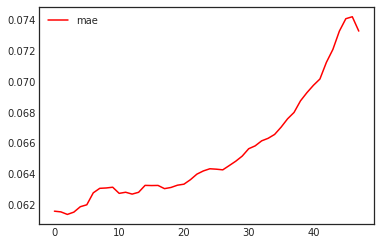

In [22]:
fig = plt.figure()
x = np.arange(48)
plt.plot(x, testsetpatchdistancelosses, '-r', label='mae')
plt.legend();

In [23]:
# np.save("{}_distanceloss800_1300".format(modelname),testsetpatchdistancelosses)

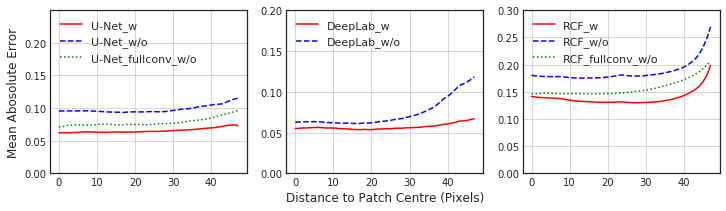

In [24]:
import numpy as np
unetoverlaploss = np.load("unet_LRoverlap_0.5Loss12_0.5Loss3_addafterepoch4_seed1_distanceloss800_1300.npy")
unetwithoutoverlaploss = np.load("unet_withoutoverlap_seed1_distanceloss800_1300.npy")
unetfullwithoutoverlaploss = np.load("unet_fullconv_withoutoverlap_seed1_distanceloss800_1300.npy")
fig = plt.figure(figsize=(12,3))
x = np.arange(48)
ax = plt.subplot(1,3,1)

ax.plot(x, unetoverlaploss, '-r', label='U-Net_w')
ax.plot(x, unetwithoutoverlaploss, '--b', label='U-Net_w/o')
ax.plot(x, unetfullwithoutoverlaploss, ':g', label='U-Net_fullconv_w/o')
ax.legend( ncol=1, fontsize=11,loc='upper left');
ax.set_ylim(0, 0.25)
ax.set_yticks(np.arange(0,25, step=5)/100)
ax.grid()
ax.set_ylabel('Mean Abosolute Error', fontsize=12)

deeplaboverlaploss = np.load("deeplab_LRoverlap_0.5Loss12_1Loss3_addafterepoch2_distanceloss800_1300.npy")
deeplabwithoutoverlaploss = np.load("deeplab_withoutoverlap_distanceloss800_1300.npy")
ax = plt.subplot(1,3,2)
ax.plot(x, deeplaboverlaploss, '-r', label='DeepLab_w')
ax.plot(x, deeplabwithoutoverlaploss, '--b', label='DeepLab_w/o')
ax.set_yticks(np.arange(0,25, step=5)/100)
ax.grid()
ax.legend( ncol=1, fontsize=11,loc='upper left');
ax.set_xlabel('Distance to Patch Centre (Pixels)', fontsize=12) #, fontsize=16

rcfoverlaploss = np.load("rcf_LRoverlap_0.5Loss12_0.5Loss3_addafterepoch10_distanceloss800_1300.npy")
rcfwithoutoverlaploss = np.load("rcf_withoutoverlap_distanceloss800_1300.npy")
rcffullwithoutoverlaploss = np.load("rcf_fullconv_withoutoverlap_seed1_distanceloss800_1300.npy")
ax = plt.subplot(1,3,3)
ax.plot(x, rcfoverlaploss, '-r', label='RCF_w')
ax.plot(x, rcfwithoutoverlaploss, '--b', label='RCF_w/o')
ax.plot(x, rcffullwithoutoverlaploss, ':g', label='RCF_fullconv_w/o')
ax.set_yticks(np.arange(0,35, step=5)/100)
ax.grid()
ax.legend( ncol=1, fontsize=11);


plt.savefig("distance_mse_bw.png", bbox_inches = 'tight')